In [1]:
# force torch to use CPU
import torch
# torch.cuda.empty_cache()
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from ad_toolkit.datasets import NabDataset, SupervisedDataset
from ad_toolkit.detectors import AutoEncoder, VariationalAutoEncoder, LSTM_AD, LSTM_ED, Donut
from ad_toolkit.evaluation import Result

/home/pawel/miniconda3/envs/ad_toolkit/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pawel/miniconda3/envs/ad_toolkit/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pawel/miniconda3/envs/ad_toolkit/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pawel/miniconda3/envs/ad_too

In [10]:
def max_metric(scores, targets, threshold_range, metric):
    best_metric = -1
    best_result = None
    best_threshold = 0
    for threshold in threshold_range:
        labels = (scores > threshold).astype(np.int32)
        result = Result(labels, targets)
        current_metric = getattr(result, metric, -1)
        if current_metric > best_metric:
            best_metric = current_metric
            best_result = result
            best_threshold = threshold
    return best_result, best_threshold, best_metric

def best_result(predictions, targets, max_error=None):
    """Try various threshold levels to get best scores."""
    
    if max_error is None:
        threshold_range = np.linspace(
            np.min(predictions), 
            min(3*np.mean(predictions), np.max(predictions)),
#             np.max(predictions),
            200,
        )
    else:
        threshold_range = np.linspace(0, max_error, 100)
        
    if np.any(targets):
        # If dataset contains anomalies maximize f1 score.
        result, threshold, _ = max_metric(predictions, targets, threshold_range, 'f1')
    else:
        # If dataset contains no anomalies maximize accuracy.
        result, threshold, _ = max_metric(predictions, targets, threshold_range, 'accuracy')
    return result, threshold

No handles with labels found to put in legend.


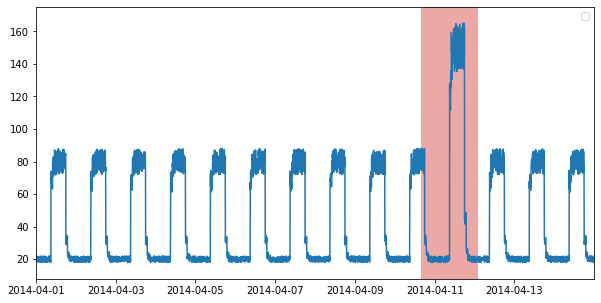

In [4]:
nab = NabDataset()
nab.plot()

In [5]:
%%capture logs
_, y = nab.data
x = nab.get_train_samples(normalize=True)
x_train = x[y != 1]

with tf.Graph().as_default():
    model = Donut(x_dim=120)
    model.train(x_train, epochs=512)
    scores = model.predict(x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmprouc_e0m/variables.dat-2400


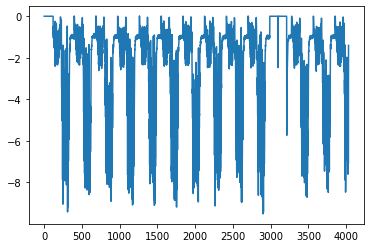

In [6]:
plt.plot(scores)

Result(accuracy=0.89,
	precision=0.47,
	recall=0.5,
	f1=0.49,
	roc_auc=0.72,
	y_pred%=0.10689484126984126,
	y_label%=0.09995039682539683,
)


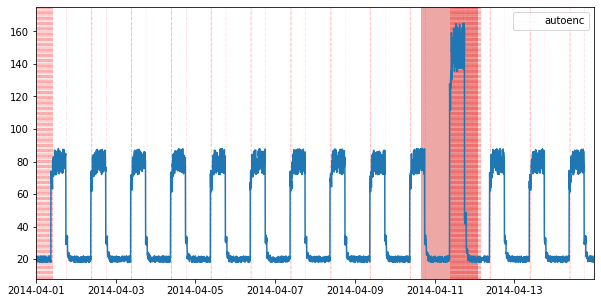

In [7]:
# scores = np.exp(scores)
result, threshold = best_result(scores, y)
anomalies = (scores > threshold).astype(np.int32)
print(result)
nab.plot(anomalies={'autoenc': anomalies})
plt.show()

In [8]:
threshold

-0.11241467154804852

In [36]:
NabDataset.datasets()

defaultdict(list,
            {'artificialNoAnomaly': ['art_daily_no_noise.csv',
              'art_daily_perfect_square_wave.csv',
              'art_daily_small_noise.csv',
              'art_flatline.csv',
              'art_noisy.csv'],
             'artificialWithAnomaly': ['art_daily_flatmiddle.csv',
              'art_daily_jumpsdown.csv',
              'art_daily_jumpsup.csv',
              'art_daily_nojump.csv',
              'art_increase_spike_density.csv',
              'art_load_balancer_spikes.csv'],
             'realAWSCloudwatch': ['ec2_cpu_utilization_24ae8d.csv',
              'ec2_cpu_utilization_53ea38.csv',
              'ec2_cpu_utilization_5f5533.csv',
              'ec2_cpu_utilization_77c1ca.csv',
              'ec2_cpu_utilization_825cc2.csv',
              'ec2_cpu_utilization_ac20cd.csv',
              'ec2_cpu_utilization_c6585a.csv',
              'ec2_cpu_utilization_fe7f93.csv',
              'ec2_disk_write_bytes_1ef3de.csv',
              'ec2_disk_w

Result(accuracy=0.95,
	precision=0.95,
	recall=0.5,
	f1=0.66,
	roc_auc=0.75,
	y_pred%=0.05282738095238095,
	y_label%=0.09995039682539683,
)


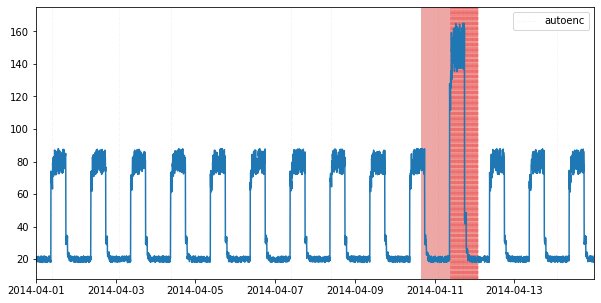

In [17]:
# realKnownCause/rogue_agent_key_hold.csv
# artificialWithAnomaly/art_daily_jumpsup.csv
dataset = NabDataset(dataset="artificialWithAnomaly", file="art_daily_jumpsup.csv")
# dataset.plot()
# plt.show()

model = AutoEncoder(window_size=100, layers=(64, 32, 16), latent_size=10)
x, y = dataset.data
x_train = x[y != 1]
model.train(x_train, epochs=40)

scores = model.predict(x)
result, threshold = best_result(scores, y)
anomalies = (scores > threshold).astype(np.int32)

dataset.plot(anomalies={'autoenc': anomalies})
print(result)
plt.show()

In [18]:
anomalies.sum()

213

Result(accuracy=0.87,
	precision=0.36,
	recall=0.4,
	f1=0.38,
	roc_auc=0.66,
	y_pred%=0.11080367249402591,
	y_label%=0.09986165262231166,
)


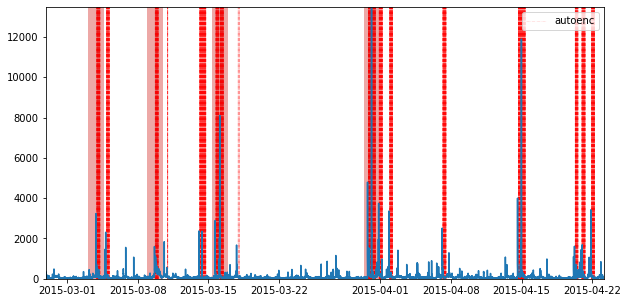

In [12]:
dataset.plot(anomalies={'autoenc': anomalies}, anomaly_style_kwargs={'lw': 0.5, 'ls': '-.', 'alpha': 0.2})
print(result)
plt.show()

In [6]:
RESULTS_ROOT = pathlib.Path('../results/nab_results')

def save_results(index, results, anomalies, detector_name):
    root_folder = RESULTS_ROOT / detector_name
    scores = [
        [r.accuracy, r.f1, r.precision, r.recall, r.roc_auc]
        for r
        in results
    ]
    columns = ['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc']
    
    if not root_folder.exists():
        root_folder.mkdir(parents=True)
    
    pd.DataFrame(data=scores, index=index, columns=columns).to_csv(root_folder/ '..' / f"{detector}_scores.csv")
    for idx, report in zip(index, anomalies):
        dataset, file = idx.split('/')
        file = f"{detector_name}_{file}"
        folder = root_folder / dataset
        if not folder.exists():
            folder.mkdir(parents=True)
        report.to_csv(folder / file)
        
    # Save results files in proper hierarchy
#     pd.DataFrame(data=np.array(anomalies).T, columns=index).to_csv(anomalies_file_path)

In [19]:

# autoencoder_rogue_agent_key_hold.csv
# datasets = NabDataset.datasets()
# datasets = {'artificialWithAnomaly': ['art_daily_flatmiddle.csv', 'art_daily_jumpsup.csv',]}
def test_for_all(model_factory, detector_name):
    index = []
    all_results = []
    all_anomalies = []
#     for dataset, files in NabDataset.datasets():
    for dataset_name, files in datasets.items():
        for file in files:
            print(f"Testing on {dataset_name}/{file} ...")
            dataset = NabDataset(dataset=dataset_name, file=file)
            x, y = dataset.data
            x_train = x[y != 1]

            model = model_factory()
            model.train(x_train, epochs=50)
            
            scores = model.predict(x)
            result, threshold = best_result(scores, y)
            print(result)
            
            anomalies = (scores > threshold).astype(np.float32)
        
            index.append(f"{dataset_name}/{file}")
            all_results.append(result)
            
            anomaly_report = x.copy()
            anomaly_report['anomaly_score'] = anomalies
            anomaly_report['label'] = np.array(y).astype(np.int32)
            all_anomalies.append(anomaly_report)
            
    save_results(index, all_results, all_anomalies, detector_name)

In [20]:
test_for_all(
    lambda: AutoEncoder(window_size=100, layers=(64, 32, 16), latent_size=10), 
    detector_name="autoencoder",
)

Testing on artificialNoAnomaly/art_daily_no_noise.csv ...
Result(accuracy=1.0,
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.003472222222222222,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_daily_perfect_square_wave.csv ...
Result(accuracy=1.0,
	precision=1.0,
	recall=1.0,
	f1=1.0,
	roc_auc=nan,
	y_pred%=0.0,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_daily_small_noise.csv ...
Result(accuracy=1.0,
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.00496031746031746,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_flatline.csv ...
Result(accuracy=1.0,
	precision=1.0,
	recall=1.0,
	f1=1.0,
	roc_auc=nan,
	y_pred%=0.0,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_noisy.csv ...
Result(accuracy=1.0,
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.004464285714285714,
	y_label%=0.0,
)
Testing on artificialWithAnomaly/art_daily_flatmiddle.csv ...
Result(accuracy=0.31,
	precision=0.12,
	recall=0.96,
	f1=0.22,
	roc_auc=0.6,
	y

Result(accuracy=0.78,
	precision=0.22,
	recall=0.47,
	f1=0.3,
	roc_auc=0.64,
	y_pred%=0.2160037002775208,
	y_label%=0.10037002775208141,
)
Testing on realTraffic/occupancy_6005.csv ...
Result(accuracy=0.77,
	precision=0.19,
	recall=0.39,
	f1=0.26,
	roc_auc=0.6,
	y_pred%=0.2046218487394958,
	y_label%=0.1004201680672269,
)
Testing on realTraffic/occupancy_t4013.csv ...
Result(accuracy=0.91,
	precision=0.58,
	recall=0.5,
	f1=0.54,
	roc_auc=0.73,
	y_pred%=0.0868,
	y_label%=0.1,
)
Testing on realTraffic/speed_6005.csv ...
Result(accuracy=0.94,
	precision=0.99,
	recall=0.42,
	f1=0.59,
	roc_auc=0.71,
	y_pred%=0.0404,
	y_label%=0.0956,
)
Testing on realTraffic/speed_7578.csv ...
Result(accuracy=0.87,
	precision=0.39,
	recall=0.52,
	f1=0.45,
	roc_auc=0.71,
	y_pred%=0.13575865128660158,
	y_label%=0.10292812777284827,
)
Testing on realTraffic/speed_t4013.csv ...
Result(accuracy=0.92,
	precision=0.62,
	recall=0.52,
	f1=0.57,
	roc_auc=0.74,
	y_pred%=0.0841683366733467,
	y_label%=0.10020040080160321

In [56]:
test_for_all(
    lambda: LSTM_AD(window_size=100, hidden_size=200), 
    detector_name="lstm_ad",
)

Testing on artificialWithAnomaly/art_daily_flatmiddle.csv ...


TypeError: __init__() got an unexpected keyword argument 'window_size'

In [10]:
# torch.Size([32, 30, 1])
t = torch.randn(32, 30, 1)
t.mean(axis=1).mean()

tensor(-0.0137)

In [11]:
t

tensor([[[-5.7412e-01],
         [-3.3271e-01],
         [ 1.0548e+00],
         [-2.5243e-01],
         [ 5.7456e-01],
         [-2.9093e-01],
         [ 8.5627e-01],
         [-9.6624e-01],
         [-2.9247e-01],
         [ 1.2596e+00],
         [-7.5072e-01],
         [ 1.7667e-01],
         [ 4.2549e-01],
         [ 9.8255e-01],
         [ 5.5173e-01],
         [-1.7893e+00],
         [ 1.4503e+00],
         [ 2.8529e-02],
         [ 4.1508e-01],
         [-1.1091e+00],
         [-1.1963e+00],
         [ 1.2417e+00],
         [-2.4205e-01],
         [ 9.3989e-01],
         [-1.4105e+00],
         [ 1.3473e-02],
         [ 3.7993e-01],
         [ 6.4869e-01],
         [-5.9366e-01],
         [ 1.7333e-01]],

        [[ 6.7001e-01],
         [-8.8832e-01],
         [ 8.6146e-01],
         [-6.0529e-01],
         [-1.1462e+00],
         [ 1.6359e+00],
         [-4.5026e-01],
         [-6.1577e-01],
         [ 6.7514e-01],
         [ 1.1707e+00],
         [-2.3610e+00],
         [-1.7